In [1]:
import os 
import numpy as np
import scipy.stats as st
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from matplotlib.ticker import PercentFormatter, FuncFormatter
from statsmodels.distributions.empirical_distribution import ECDF
import dataframe_image as dfi # for saving styled data frame print-out table as png

pd.set_option('display.max_columns', 15)
pd.set_option('display.max_rows', 50)
pd.options.display.float_format = '{:,.4f}'.format

%matplotlib inline
plt.rcParams['figure.figsize'] = (10, 6)

# Makes graphs crisp. Only use if you don't have a lot of points/lines on your graph.
%config InlineBackend.figure_formats = ['svg', 'retina'] # use svg, then retina if svg is not supported

In [2]:
# set paths and create dirs 
base_dir = '../..'
data_dir = os.path.join(base_dir, 'data')
helper_dir = os.path.join(base_dir, 'helper')
output_dir = os.path.join(base_dir, 'output')
png_dir = os.path.join(output_dir, 'png')
csv_dir = os.path.join(output_dir, 'csv')
os.makedirs(png_dir, exist_ok=True)
os.makedirs(csv_dir, exist_ok=True)

In [3]:
# load helper functions
%run {helper_dir}/plot.py
%run {helper_dir}/calc_value_growth_history.py

## Input

In [4]:
chain = 'Avalanche'

In [5]:
reward_token = 'AVAX' if chain == 'Avalanche' else 'ETH'

In [6]:
data_fnames = os.listdir(os.path.join(data_dir, chain)) # names of all data files

# collect the names of the files for this analysis
fnames = dict()
for fname in data_fnames:
    if fname.startswith('Glp Price Comparison'):
        fnames['Glp Price Comparison'] = fname
    if fname.startswith('AUM & Glp Supply'):
        fnames['AUM & Glp Supply'] = fname
    if fname.startswith('Fees'):
        fnames['Fees'] = fname                
fnames

{'Fees': 'Fees_2022-01-06_2022-07-18.csv',
 'Glp Price Comparison': 'Glp Price Comparison_2022-01-06_2022-07-18.csv',
 'AUM & Glp Supply': 'AUM & Glp Supply_2022-01-06_2022-07-17.csv'}

## Prep Data

In [7]:
# read GLP price data
glp_prices = (pd.read_csv(os.path.join(data_dir, chain, fnames['Glp Price Comparison']), 
                         index_col='Date', parse_dates=['Date'])
                .iloc[:-1, ] # drop the last row since it may not be a full day
                .loc[:, ['glpPrice', 'glpPlusFees']]
                .rename(columns={'glpPrice':'glp_price', 'glpPlusFees':'glp_plusfees_price'})
             )
glp_prices.tail()

,glp_price,glp_plusfees_price
Date,,
2022-07-13,0.7053,0.8820
2022-07-14,0.7178,0.8949
2022-07-15,0.7255,0.9028
2022-07-16,0.7434,0.9211
2022-07-17,0.7370,0.9148


In [8]:
# read glp supply data
glp_supply = (pd.read_csv(os.path.join(data_dir, chain, fnames['AUM & Glp Supply']), 
                           parse_dates=['Date'], index_col='Date', usecols=['Date', 'glpSupply'])
                .iloc[:-1, ] # drop the last row since it may not be a full day
                .rename(columns={'glpSupply':'glp_supply'})
                .squeeze()
              )
glp_supply.tail()

Date
2022-07-12   114,975,889.7942
2022-07-13   115,182,942.5898
2022-07-14   116,017,313.3520
2022-07-15   116,422,841.6034
2022-07-16   116,672,755.3681
Name: glp_supply, dtype: float64

In [9]:
# # calculate daily GLP pool dollar value
# glp_pool_value = glp_prices['glp_price'] * glp_supply
# glp_pool_value.name = 'glp_pool_value'
# glp_pool_value

In [10]:
# read fees data
fees = (pd.read_csv(os.path.join(data_dir, chain, fnames['Fees']), 
                    parse_dates=['Date'], index_col='Date', 
                    # ignore the last col "Cumulative" cuz it's NOT the daily total, but cumulative daily total 
                    usecols=range(6))
          .iloc[:-1, ] # drop the last row since it may not be a full day
       )
fees.columns = fees.columns.str.lower().str.replace(' ', '_') + '_fees'
# calc daily total 
fees['total_fees'] = fees.sum(axis=1)
fees.tail()

,swap_fees,margin_trading_fees,mint_glp_fees,burn_glp_fees,liquidation_fees,total_fees
Date,,,,,,
2022-07-13,"32,223.7466","53,872.7211",382.4411,334.5966,809.3813,"87,622.8867"
2022-07-14,"6,905.3031","48,594.3692",766.9748,599.0336,83.2078,"56,948.8884"
2022-07-15,"15,355.0702","21,500.3069",632.5058,603.7430,10.5858,"38,102.2118"
2022-07-16,"26,316.1237","37,952.4357",585.3280,"1,475.9366",542.4496,"66,872.2736"
2022-07-17,"7,570.5343","20,414.6301",825.0635,"1,060.3630",113.7271,"29,984.3180"


In [11]:
# how much fees (in dollars) does 1 GLP earn? Think of it as daily dividend
fees_per_share = fees['total_fees'] * 0.7 / glp_supply
fees_per_share.name = 'fees_per_share'
fees_per_share

Date
2022-01-06   0.0031
2022-01-07   0.0013
2022-01-08   0.0012
2022-01-09   0.0037
2022-01-10   0.0056
              ...  
2022-07-13   0.0005
2022-07-14   0.0003
2022-07-15   0.0002
2022-07-16   0.0004
2022-07-17      NaN
Name: fees_per_share, Length: 193, dtype: float64

## Set up 

allow users to enter their own numbers and see output

In [12]:
# user input
start_date = glp_prices.index[1]     # investment start date, can use a date string, for example, '2022-06-15'
init_capital = 10_000                # dollars

In [13]:
# what's my purchase price?
init_price = glp_prices.loc[start_date, 'glp_price'] # use the avg daily price on start date 
# how much GLP did I buy?
init_shares = init_capital / init_price
print('Purchase price: ${:.3f}'.format(init_price), 'Shares: {:.4f}'.format(init_shares))

Purchase price: $1.156 Shares: 8652.3451


In [14]:
res = dict() # hold output growth paths

## Reinvest Rewards

In [15]:
value_growth_daily_compounded = calc_value_growth_history(glp_prices.glp_plusfees_price, start_date, init_capital)
value_growth_daily_compounded

Investment started on 2022-01-07 00:00:00 



2022-01-07   10,000.0000
2022-01-08    9,918.7506
2022-01-09   10,020.2684
2022-01-10    9,670.1626
2022-01-11    9,959.3186
                 ...    
2022-07-13    7,622.7005
2022-07-14    7,734.1310
2022-07-15    7,802.3066
2022-07-16    7,961.0570
2022-07-17    7,906.7206
Name: value, Length: 192, dtype: float64

In [16]:
name = 'Reinvest {} rewards daily'.format(reward_token)
res[name] = value_growth_daily_compounded

In [17]:
# double check by running through the calculation of manually reinvesting fees daily and compounding
daily_shares = [init_shares]
subdf_prices = glp_prices.loc[start_date:]

for i in range(len(subdf_prices)-1):
    shares_today = daily_shares[-1] # assume we buy shares at day end so we don't earn any fees today
    # our shares start earning fees tomorrow. This is to match with the data which gives the same
    # glp_price and glp_plusfees_price at inception.
    fees_earned_tomorrow = fees_per_share[i+1] * shares_today
    price_tomorrow = subdf_prices.glp_price[i+1]
    daily_shares.append(shares_today + fees_earned_tomorrow / price_tomorrow)
daily_shares = pd.Series(daily_shares)

# calc daily values
daily_shares * subdf_prices.glp_price.values

0     10,000.0000
1      9,919.4130
2      9,999.8196
3      9,632.1186
4      9,939.1944
          ...    
187    7,283.5080
188    7,418.6094
189    7,501.3175
190    7,689.4621
191    7,626.7315
Length: 192, dtype: float64

In [18]:
value_growth_daily_compounded

2022-01-07   10,000.0000
2022-01-08    9,918.7506
2022-01-09   10,020.2684
2022-01-10    9,670.1626
2022-01-11    9,959.3186
                 ...    
2022-07-13    7,622.7005
2022-07-14    7,734.1310
2022-07-15    7,802.3066
2022-07-16    7,961.0570
2022-07-17    7,906.7206
Name: value, Length: 192, dtype: float64

our manually calculation and the calculation using `glp_plusfees_price` give similar results. The differences are probably due to `glp_plusfees_price` more accurately reflect reality. For example, it might've factored fees into prices at a more granular frequency as hourly, minutely, or secondly. 

## Sell rewards into USD instead of reinvesting into GLP

In [19]:
# calc investment value due to GLP price movement
value_growth_price_driven = calc_value_growth_history(glp_prices.glp_price, start_date, init_capital)
value_growth_price_driven

Investment started on 2022-01-07 00:00:00 



2022-01-07   10,000.0000
2022-01-08    9,908.2875
2022-01-09    9,978.2313
2022-01-10    9,579.6372
2022-01-11    9,836.9410
                 ...    
2022-07-13    6,102.1844
2022-07-14    6,210.7659
2022-07-15    6,277.0351
2022-07-16    6,432.4907
2022-07-17    6,376.5430
Name: value, Length: 192, dtype: float64

In [20]:
# how much fees do we earn per day?
fees_earned = fees_per_share.loc[start_date:] * init_shares

# assume we don't earn any fees on day1. We do this to match up the data. The glp_price and 
# glp_plusfees_price are the same on day1 => this is a good assumption. 
fees_earned[0] = 0

# # alternatively, we could assume fees we earn today is distributed to us tomorrow so we need to shift the data by 1 day.
# # the output under both assumptions don't show difference when plotted out.
# fees_earned = fees_earned.shift(1).fillna(0)

fees_earned

Date
2022-01-07    0.0000
2022-01-08   10.3726
2022-01-09   31.6870
2022-01-10   48.0988
2022-01-11   32.1740
               ...  
2022-07-13    4.6075
2022-07-14    2.9730
2022-07-15    1.9822
2022-07-16    3.4714
2022-07-17       NaN
Name: fees_per_share, Length: 192, dtype: float64

In [21]:
# add money earned from trader and fees to investment value determined by price alone
value_growth_no_compounding = value_growth_price_driven + fees_earned # + traders_money_earned
value_growth_no_compounding.name = 'value'
value_growth_no_compounding

2022-01-07   10,000.0000
2022-01-08    9,918.6602
2022-01-09   10,009.9183
2022-01-10    9,627.7360
2022-01-11    9,869.1150
                 ...    
2022-07-13    6,106.7918
2022-07-14    6,213.7389
2022-07-15    6,279.0173
2022-07-16    6,435.9621
2022-07-17           NaN
Name: value, Length: 192, dtype: float64

In [22]:
name = 'Sell {} rewards into USD daily'.format(reward_token)
res[name] = value_growth_no_compounding

## Compare

In [23]:
df = pd.DataFrame(res)
df

,Reinvest AVAX rewards daily,Sell AVAX rewards into USD daily
2022-01-07,"10,000.0000","10,000.0000"
2022-01-08,"9,918.7506","9,918.6602"
2022-01-09,"10,020.2684","10,009.9183"
2022-01-10,"9,670.1626","9,627.7360"
2022-01-11,"9,959.3186","9,869.1150"
...,...,...
2022-07-13,"7,622.7005","6,106.7918"
2022-07-14,"7,734.1310","6,213.7389"
2022-07-15,"7,802.3066","6,279.0173"
2022-07-16,"7,961.0570","6,435.9621"


In [24]:
last_day = df.index[-1]

In [25]:
df_long = df.stack().to_frame().reset_index()
df_long.columns = ['Date', 'Strategy', 'Investment Value']
df_long.head()

,Date,Strategy,Investment Value
0,2022-01-07,Reinvest AVAX rewards daily,"10,000.0000"
1,2022-01-07,Sell AVAX rewards into USD daily,"10,000.0000"
2,2022-01-08,Reinvest AVAX rewards daily,"9,918.7506"
3,2022-01-08,Sell AVAX rewards into USD daily,"9,918.6602"
4,2022-01-09,Reinvest AVAX rewards daily,"10,020.2684"


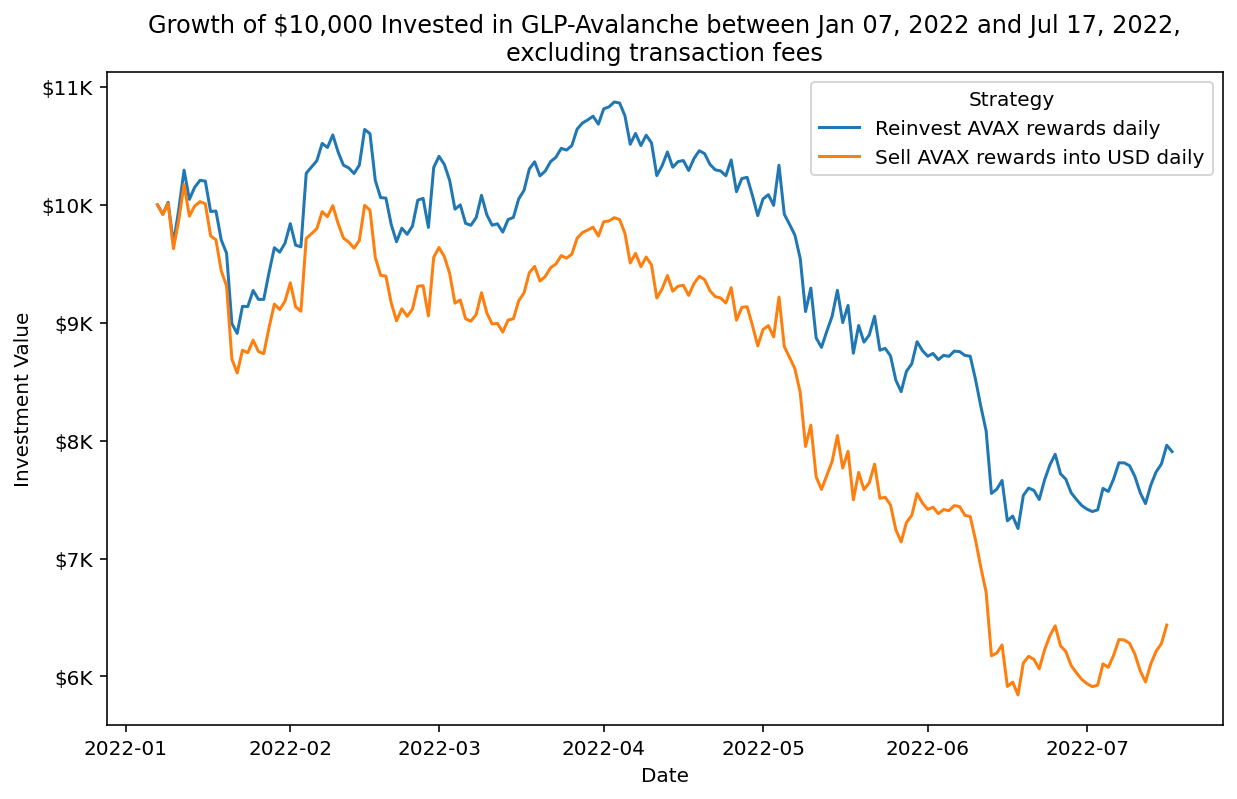

In [26]:
ax = sns.lineplot(data=df_long, x='Date', y='Investment Value', hue='Strategy')
ax.set(title="Growth of ${:,} Invested in GLP-{} between {} and {},\nexcluding transaction fees".format(init_capital, chain, start_date.strftime('%b %d, %Y'), last_day.strftime('%b %d, %Y'), reward_token))
formatter = FuncFormatter(human_format_dollar_or_num(dollar=True, decimals=0))
ax.yaxis.set_major_formatter(formatter)

fname = 'glp_compare_2strats_since_{}.png'.format(start_date.strftime('%b %d, %Y'))
plt.savefig(os.path.join(png_dir, chain, fname), dpi=300);